In [1]:
import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib as mpl


from architecture.NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE

In [2]:
# Set data files and expt name

#data_file_prefix = './data/S0-Oscillator'
#expt_name = "S0-NLSL1-Expt1-L20-b"

data_file_prefix = './data/S1-NLSL1'
expt_name = "S1-NLSL1-Expt3-b"

#data_file_prefix = './data/S2-NLSL2'
#expt_name = "S2-NLSL2-Expt1-L20-b"

In [3]:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14

In [4]:
def load_data(data_file_prefix):
    # Step 1. Load in the data
    train_u = np.load("{}_train1_u.npy".format(data_file_prefix)).astype(np.float32)
    train_f = np.load("{}_train1_f.npy".format(data_file_prefix)).astype(np.float32)
    val_u = np.load("{}_val_u.npy".format(data_file_prefix)).astype(np.float32)
    val_f = np.load("{}_val_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u = np.load("{}_test2_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f = np.load("{}_test2_f.npy".format(data_file_prefix)).astype(np.float32)

    train_data = [train_u, train_f]
    val_data = [val_u,   val_f]
    test1_data = [test_u1, test_f1]
    test2_data = [test_u,  test_f]

    return train_data, val_data, test1_data, test2_data
    
def organize_data(data):
    return [{'x': [u, f], 
                 'y': [u, f, f, u]} \
                for (u,f) in data]

def plot_predict_vs_true(i, pred_u, pred_f, u, f, title):
    
    # Grab the 'true' value
    true_u = u[i,:]
    true_F = f[i,:]

    # And predicted value
    predict_u = pred_u[i,:]
    predict_F = pred_f[i,:]

    # create a space vector
    x = np.linspace(0,2*np.pi, predict_u.shape[0])
    
    # Create the figure
    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    true_line = dict(color='cornflowerblue', lw=2)
    pred_line = dict(linestyle='--', color='k', alpha=0.8)

    ax1.plot(x, true_u, **true_line, label=r"True $u(x)$")
    ax1.plot(x, predict_u, **pred_line, label=r"Predicted u(x)")
    ax1.set_title("{}: U(x)".format(title))
    #ax1.set_xlabel("x")
    ax1.set_ylabel("u(x)")
    ax1.legend(loc='best')

    ax2.plot(x, true_F, **true_line, label=r"True $F(x)$")
    ax2.plot(x, predict_F, **pred_line, label=r"Predicted F(x)")
    ax2.set_title("{}: F(x)".format(title))
    ax2.set_xlabel("x")
    ax2.set_ylabel("F(x)")
    ax2.legend(loc='best')

    plt.show()

In [5]:
def rel_mse(pred, true, den_nonzero=1e-5):
    num = np.mean(np.square(pred-true), axis=-1)
    den = np.mean(np.square(true), axis=-1)
    den += den_nonzero
    return np.divide(num, den) 
    
    
def find_sample(u,f, full_model, mode='worst'):
    pred = full_model.predict(x=[u, f])
    
    pred_f = pred[2]
    pred_u = pred[3]
    
    f_scores = rel_mse(pred_f, f)
    u_scores = rel_mse(pred_u, u)
    
    score = np.abs(f_scores) + np.abs(u_scores)
    mean = np.mean(score)
    
    if mode == 'worst':
        idc = np.argmax(score)
    elif mode == 'best':
        idc = np.argmin(score)
    elif mode == 'mean':
        idc = np.argmin((score-mean)**2)
    else:
        print('{} mode not supported.'.format(mode))
        idc = np.argmin(score)
        
    return idc

def compute_losses(full_model, x, y):
    predicted_ys = full_model.predict(x=x)
    data = []
    for (pred_y, true_y) in zip(predicted_ys, y):
        data.append(rel_mse(pred_y, true_y, 1e-5))
    return data

In [6]:
# Load the best model
save_prefix = 'results/{}/'.format(expt_name)
full_model = keras.models.load_model(save_prefix + "final_model", 
                                     custom_objects={"NormalizedMeanSquaredError": NMSE})

In [7]:
# Load the data
train_data, val_data, test1_data, test2_data = load_data(data_file_prefix)

# Organize the data
datasets = organize_data([train_data, val_data, test1_data, test2_data])

In [8]:
# Score the different datasets
for dset, dtype in zip(datasets, ['Train', 'Validation', 'Test 1', 'Test 2']):
    losses = full_model.evaluate(x=dset['x'], y=dset['y'], batch_size=64, return_dict=True, verbose=0)
    print("LOSSES for {}:".format(dtype))
    print([loss for loss in losses])
    for loss in losses:
        print(losses[loss], end=", ")
    print("\n")

LOSSES for Train:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.0005806530825793743, 2.8464772185543552e-05, 1.8595676010590978e-05, 5.318881449056789e-05, 2.4337963623111136e-05, 

LOSSES for Validation:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.0007757971761748195, 3.947206641896628e-05, 0.00010401097824797034, 0.0001391903351759538, 3.705804192577489e-05, 

LOSSES for Test 1:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.0007616123766638339, 4.049436029163189e-05, 9.817932732403278e-05, 0.00013030284026172012, 3.656986154965125e-05, 

LOSSES for Test 2:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.013470388017594814, 0.002460190560668707, 0.0037336486857384443, 0.004299550782889128, 0.0025209311861544847, 



In [9]:
# Print out the optimizer learning rate:
print("\nLEARNING RATE:")
lr = full_model.optimizer.get_config()['learning_rate']
print(lr)


LEARNING RATE:
0.0006855567917227745


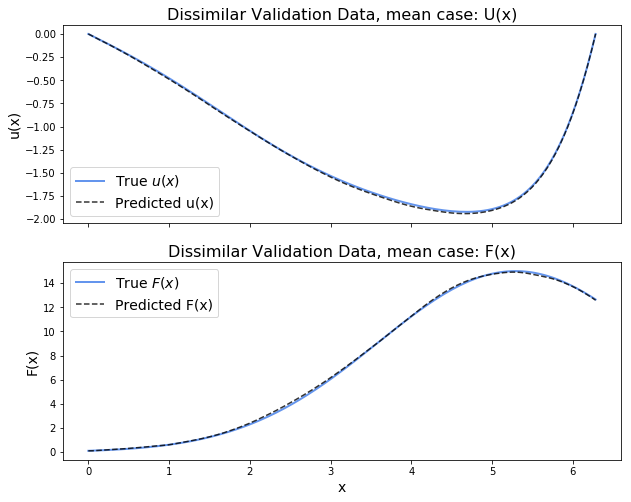

In [27]:
# Create plots from a specified solution-forcing pair
u, f = val_data
mode = 'mean'
i = find_sample(u, f, full_model, mode=mode)

# Get a prediction
_, _, F_pred, u_pred = full_model.predict((u,f))

plot_predict_vs_true(i, u_pred, F_pred, u, f, "Dissimilar Validation Data, {} case".format(mode))

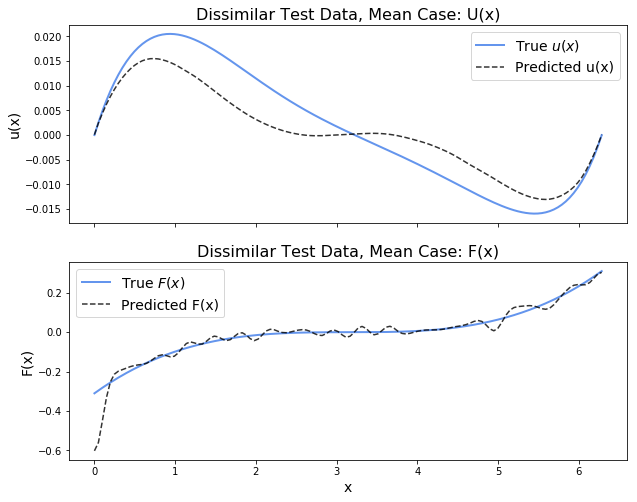

In [10]:
# Create plots from a specified solution-forcing pair
u, f = test2_data
i = find_sample(u, f, full_model, mode='worst')

# Get a prediction
_, _, F_pred, u_pred = full_model.predict((u,f))

plot_predict_vs_true(i, u_pred, F_pred, u, f, "Dissimilar Test Data, Mean Case")

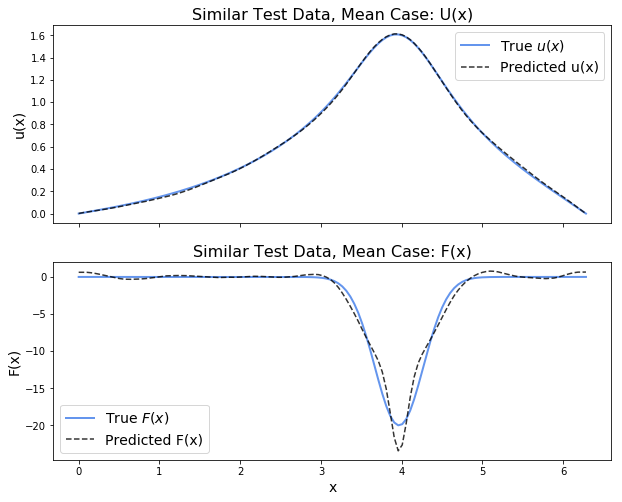

In [11]:
# Create plots from a specified solution-forcing pair
u, f = test1_data
i = find_sample(u, f, full_model, mode='worst')

# Get a prediction
_, _, F_pred, u_pred = full_model.predict((u,f))

plot_predict_vs_true(i, u_pred, F_pred, u, f, "Similar Test Data, Mean Case")

In [12]:
#
#
#opts = {'fontsize':14}
#
#fs = (8,6)
#plt.figure(figsize=fs)
#
#plt.plot(x, u_pp, 'ko', label=r'$\psi^{-1}_u \psi_u u(x)$')
#plt.plot(x, Linvf_pp, 'rx', label=r'$\psi^{-1}_u L^{-1}f$')
#plt.plot(x, val_u, label=r'True $u(x)$')
#plt.legend(bbox_to_anchor=(1.2,0.5), loc='center', **opts)
#plt.ylabel("u(x)", **opts)
#plt.xlabel("x", **opts)
#
#plt.figure(figsize=fs)
#plt.plot(x, F_pp, 'ko-', label=r'$\phi^{-1}_F \psi_F F(x)$')
#plt.plot(x, Lv_pp, 'rx-', label=r'$\phi^{-1}_u L[v(x)]$')
#plt.plot(x, val_F, label=r'True $F(x)$')
#plt.legend(bbox_to_anchor=(1.2,0.5), loc='center', **opts)
#plt.ylabel("F(x)", **opts)
#plt.xlabel("x", **opts)
#
#plt.show()

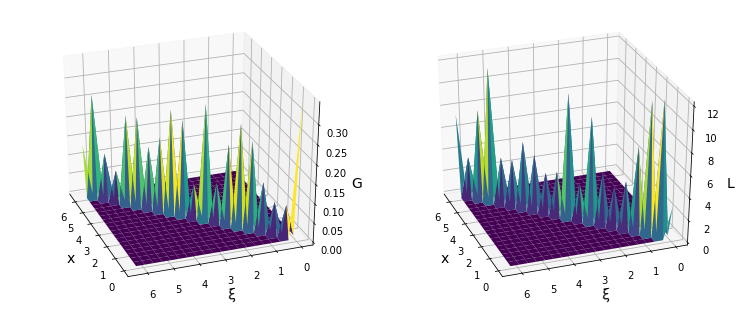

In [15]:
#utm = tf.linalg.band_part(full_model.Operator, 0, -1, name="L_upper")
L = tf.linalg.diag(full_model.Operator)
G = np.linalg.inv(L)
x = np.linspace(0,2*np.pi, L.shape[0])
X,XI = np.meshgrid(x,x)

surf_opts = dict(rcount=128, ccount=128, antialiased=True, cmap='viridis')

fig = plt.figure(figsize=(10,4))
ax = plt.axes((0, 0, 0.48, 1), projection='3d')
ax.plot_surface(X, XI, G, **surf_opts)
ax.set_xlabel("x")
ax.set_ylabel(r'$\xi$')
ax.set_zlabel('G')
ax.view_init(30,160)


ax = plt.axes((0.52, 0, 0.48, 1), projection='3d')
ax.plot_surface(X, XI, L, **surf_opts)
ax.set_xlabel("x")
ax.set_ylabel(r'$\xi$')
ax.set_zlabel('L')
ax.view_init(30,160)




plt.show()

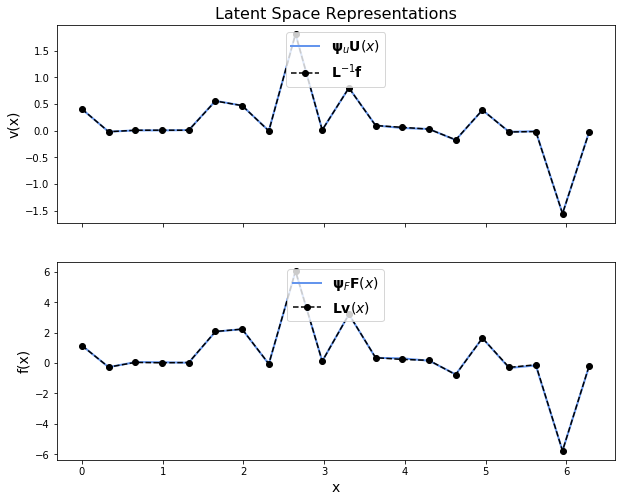

In [16]:
#mpl.rcParams['mathtext.fontset'] = 'custom'
#mpl.rcParams['mathtext.bf'] = 300

u_enc = full_model.layers[0]
F_enc = full_model.layers[2]

u, F = train_data

sample_u = u[i:i+1,:]
sample_F = F[i:i+1,:]

v = tf.matmul(u_enc(sample_u), full_model.u_Reduce)
f = tf.matmul(F_enc(sample_F), full_model.F_Reduce)

Lv = tf.matmul(v, L)
Linvf = tf.matmul(f, G)

# Set up some formatting:
aec_line = dict(color='cornflowerblue', lw=2)
cross_line = dict(color='k', linestyle='--', marker='o')
legend = dict(loc='upper center')
# Plot the results!

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,8), sharex=True)

ax1.set_title("Latent Space Representations")

ax1.plot(x, v.numpy().flatten(), **aec_line, label=r'$\mathbf{\psi}_u \mathbf{U}(x)$')
ax1.plot(x, Linvf.numpy().flatten(), **cross_line, label=r'$\mathbf{L}^{-1}\mathbf{f}$')

ax1.legend(**legend)
ax1.set_ylabel("v(x)")

ax2.plot(x, f.numpy().flatten(), **aec_line, label=r'$\mathbf{\psi}_F \mathbf{F}(x)$')
ax2.plot(x, Lv.numpy().flatten(), **cross_line, label=r'$\mathbf{L v}(x)$')

ax2.legend(**legend)
ax2.set_ylabel("f(x)")
ax2.set_xlabel("x")

plt.show()

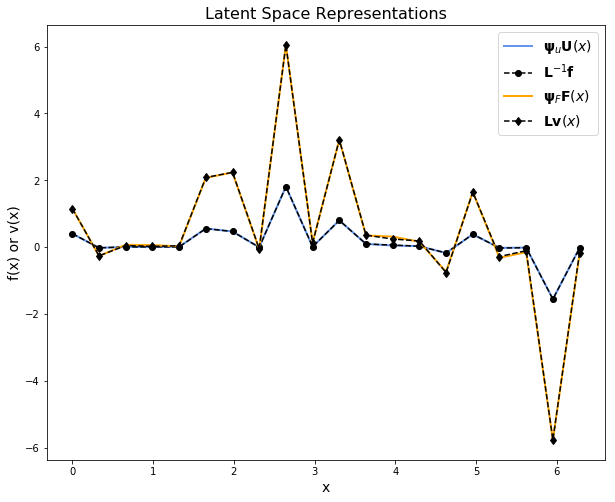

In [25]:
fig = plt.figure(figsize=(10,8))

plt.title("Latent Space Representations")

plt.plot(x, v.numpy().flatten(), **aec_line, label=r'$\mathbf{\psi}_u \mathbf{U}(x)$')
plt.plot(x, Linvf.numpy().flatten(), **cross_line, label=r'$\mathbf{L}^{-1}\mathbf{f}$')

aec_line2 = dict(color='orange', lw=2)
cross_line2 = dict(color='k', linestyle='--', marker='d')

plt.plot(x, f.numpy().flatten(), **aec_line2, label=r'$\mathbf{\psi}_F \mathbf{F}(x)$')
plt.plot(x, Lv.numpy().flatten(), **cross_line2, label=r'$\mathbf{L v}(x)$')

plt.legend(loc='upper right')
plt.ylabel("f(x) or v(x)")
plt.xlabel("x")

plt.show()

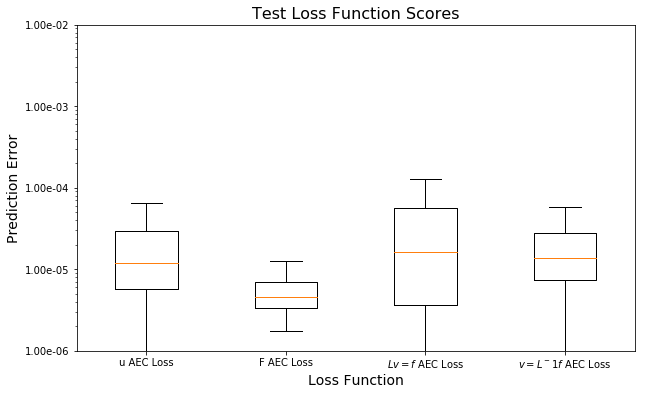

In [17]:
# Select a dataset to generate the plot from:
plot_for = 'Test'
dsets = {'Training': 0, 'Validation': 1, 'Test': 2, 'Polynomials': 3}
dset = datasets[dsets[plot_for]]

data = compute_losses(full_model, dset['x'], dset['y'])
labels = ["u AEC Loss", "F AEC Loss", r"$Lv=f$ AEC Loss", r"$v=L^-1f$ AEC Loss"]

#print(len(data), len(labels))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title(r'{} Loss Function Scores'.format(plot_for))
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_xlabel("Loss Function", fontsize=14)
ax.boxplot(data, labels=labels, showfliers=False)
#ax.ticklabel_format(axis='y', style='sci')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.ylim([1e-6, 1e-2])

plt.savefig(expt_name + "-{}-boxplot.svg".format(plot_for))
plt.savefig(expt_name + "-{}-boxplot.png".format(plot_for))

plt.show()

In [18]:
# Trying to work on colormap G representation:

#fig, ax = plt.subplots()
#im = ax.imshow(G)
#tick_array = np.linspace(0,G.shape[0],G.shape[0])
#ticks = np.asarray(list(tick_array[::int(G.shape[0]/4)])+[G.shape[0]-1])
#ax.set_xticks(ticks)
#ax.set_yticks(ticks)
##ax.set_xticks()
#labels = ["{:.1f}".format(xval) for xval in x[::20]]
#labels = ["0", r"$0.5 \pi$", r"$\pi$", r"$1.5 \pi$", r"$2 \pi$"]
#ax.set_xticklabels(labels)
#ax.set_yticklabels(labels)
#ax.set_xlabel("x")
#ax.set_ylabel(r'$\xi$')

In [19]:
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

results_path = save_prefix + "final_model_history.json"
final_results = json.load(open(results_path))

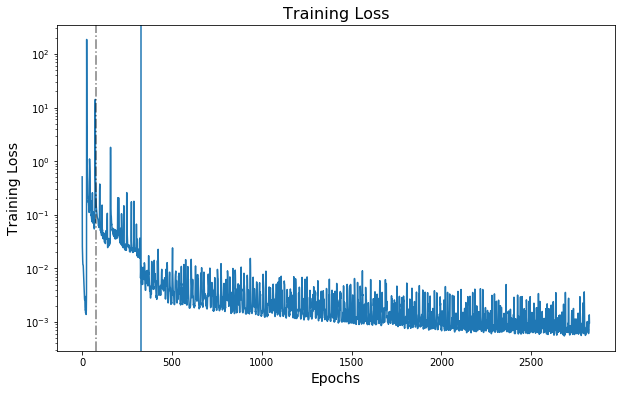

In [20]:
loss = init_results['aec_hist'][0]['loss'] + init_results['full_hist'][0]['loss'] + final_results['loss']

plt.figure(figsize=(10,6))
plt.semilogy(loss)
plt.axvline(75, linestyle='-.', color='k', alpha=0.5)
plt.axvline(325)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

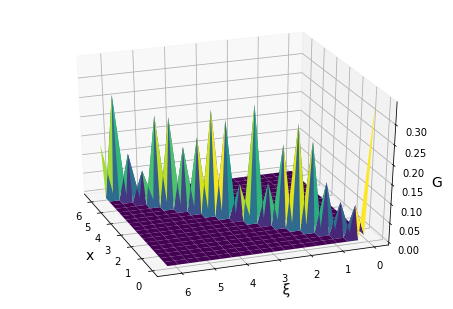

In [21]:
surf_opts = dict(rcount=128, ccount=128, antialiased=True, cmap='viridis')

fig = plt.figure(figsize=(6,4))
ax = plt.axes((0, 0, 1, 1), projection='3d')
ax.plot_surface(X, XI, G, **surf_opts)
ax.set_xlabel("x")
ax.set_ylabel(r'$\xi$')
ax.set_zlabel('G')
ax.view_init(30,160)

plt.savefig(expt_name + "-G.png", transparent=True)

plt.show()